g 1
n_test 0


WARNING    Removing unsupported flag '-w' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-O3' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-ffast-math' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-fno-finite-math-only' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-std=c++11' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Cannot use Cython, a test compilation failed: command 'g++' failed: No such file or directory (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cytho

n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9


WARNING    /tmp/ipykernel_49804/1974512319.py:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]


[10, 9, 10, 9, 9, 10, 9, 10, 9, 10]
g 2
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
[1, 1, 7, 9, 6, 4, 6, 1, 3, 5]
g 3
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
[2, 1, 8, 5, 4, 8, 4, 2, 4, 1]
g 4
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
[1, 1, 5, 4, 2, 4, 6, 1, 6, 1]
g 5
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
[13, 6, 3, 1, 10, 7, 3, 6, 2, 3]
g 6
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
[1, 5, 3, 8, 6, 3, 4, 4, 4, 6]
g 7
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
[9, 6, 11, 6, 1, 2, 3, 1, 3, 9]
g 8
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
[5, 7, 2, 4, 1, 3, 7, 1, 7, 1]
g 9
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n

WARNING    /tmp/ipykernel_49804/1974512319.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]


[16, 4, 11, 5, 6, 2, 1, 1, 27, 1]


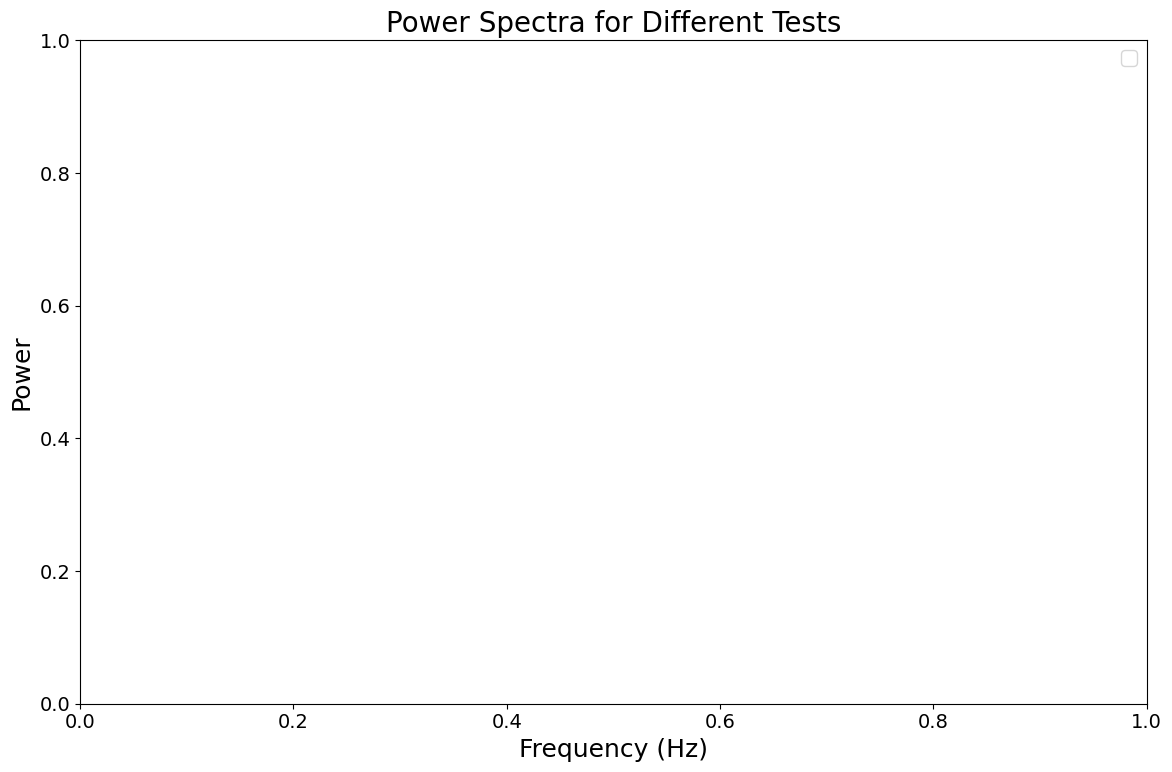

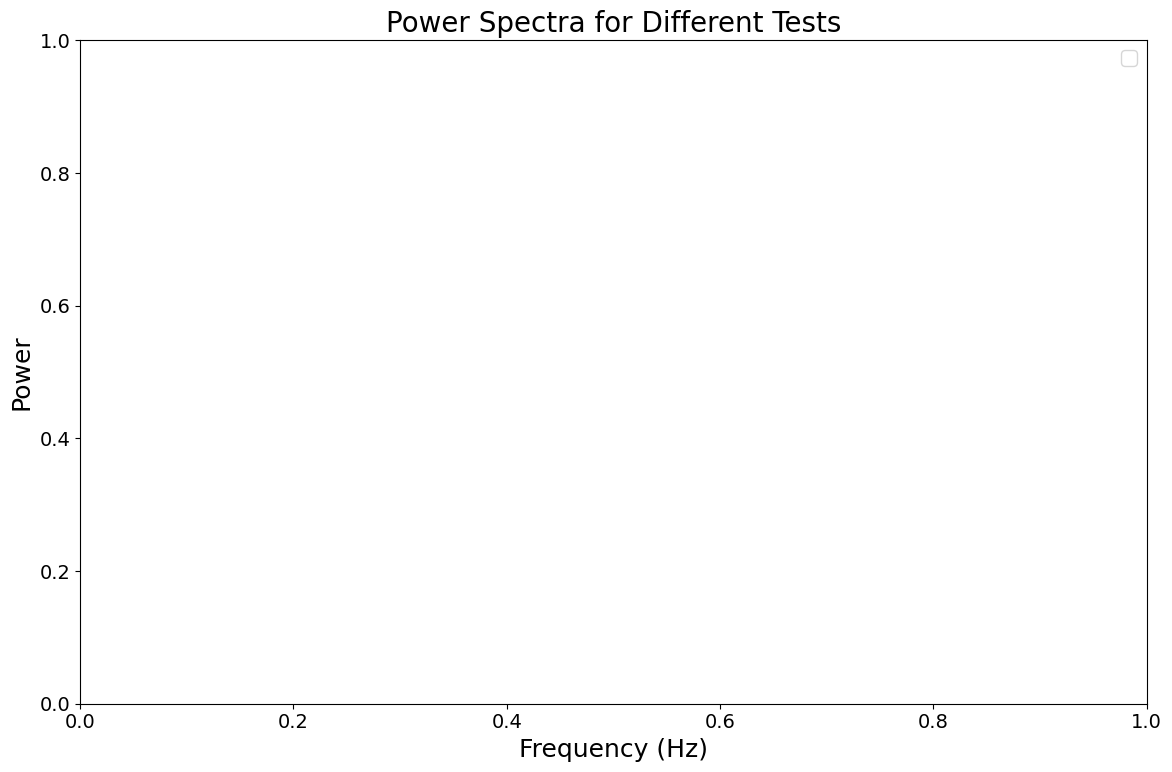

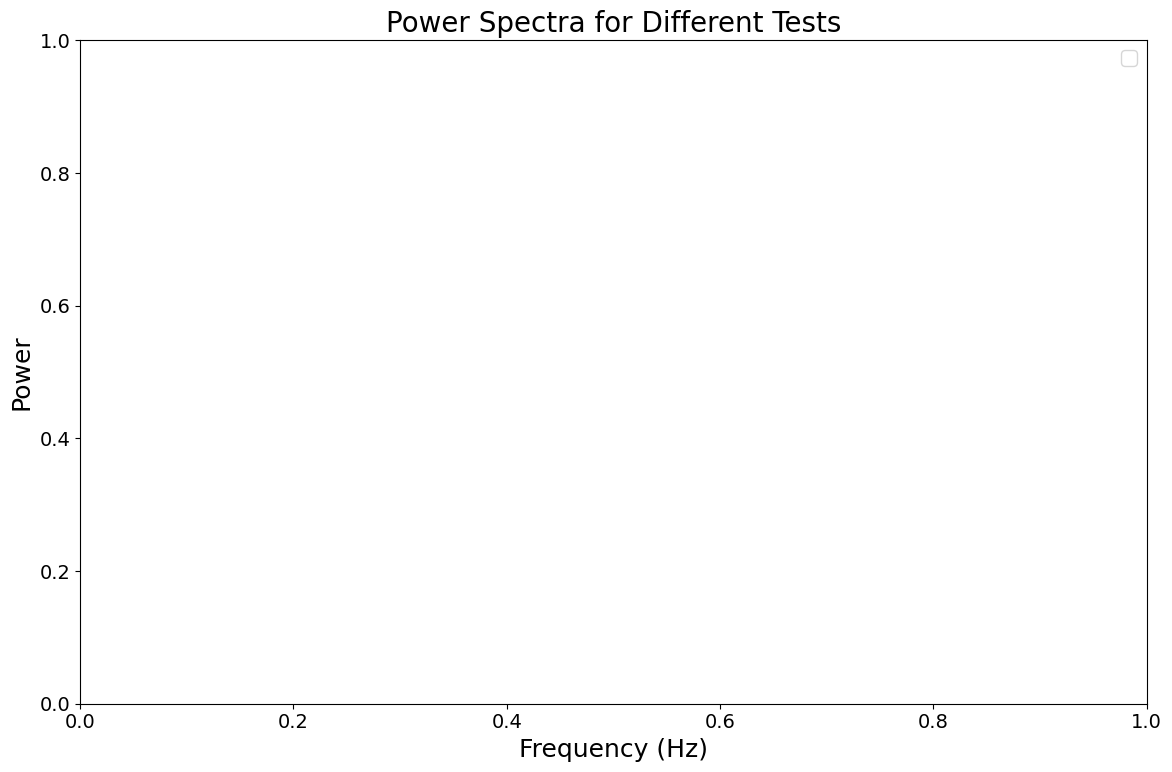

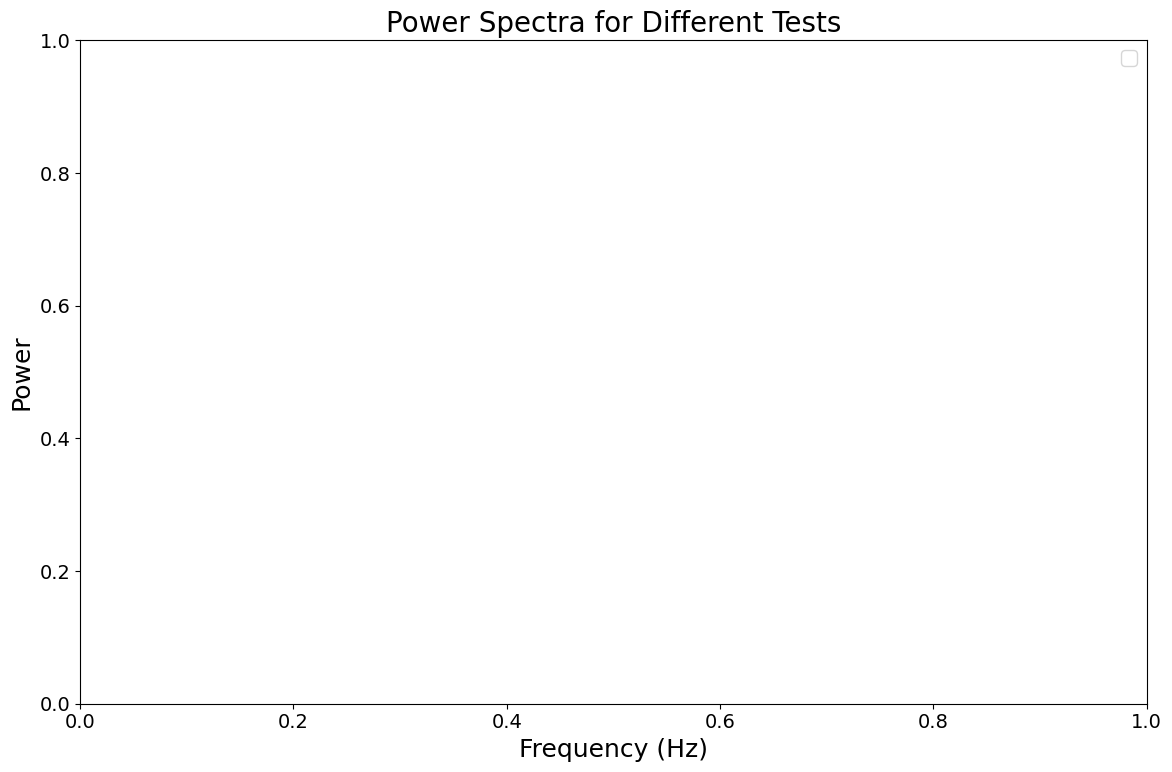

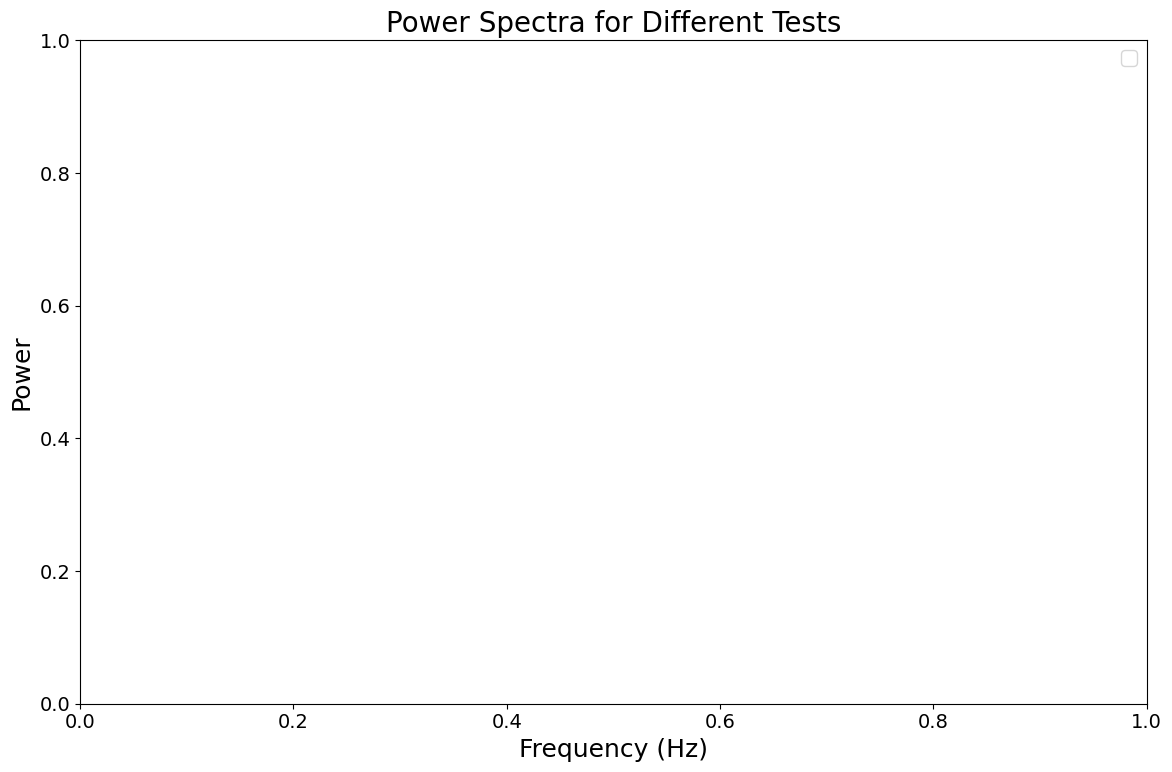

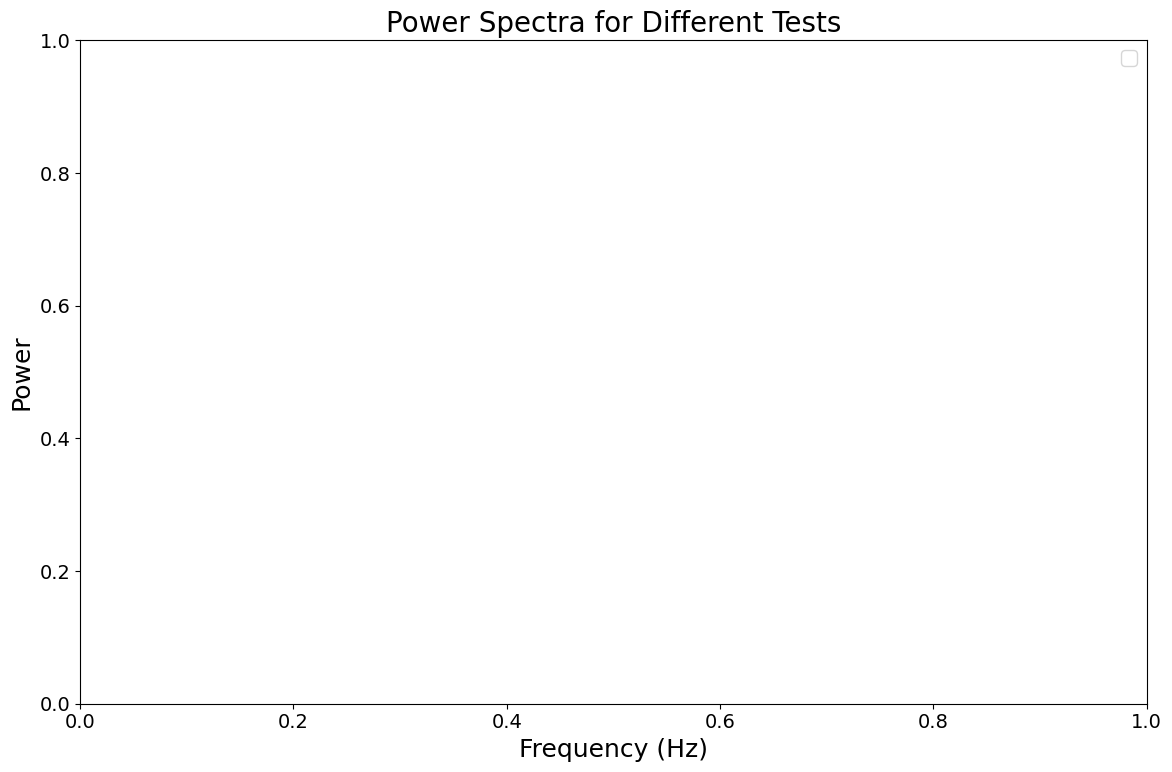

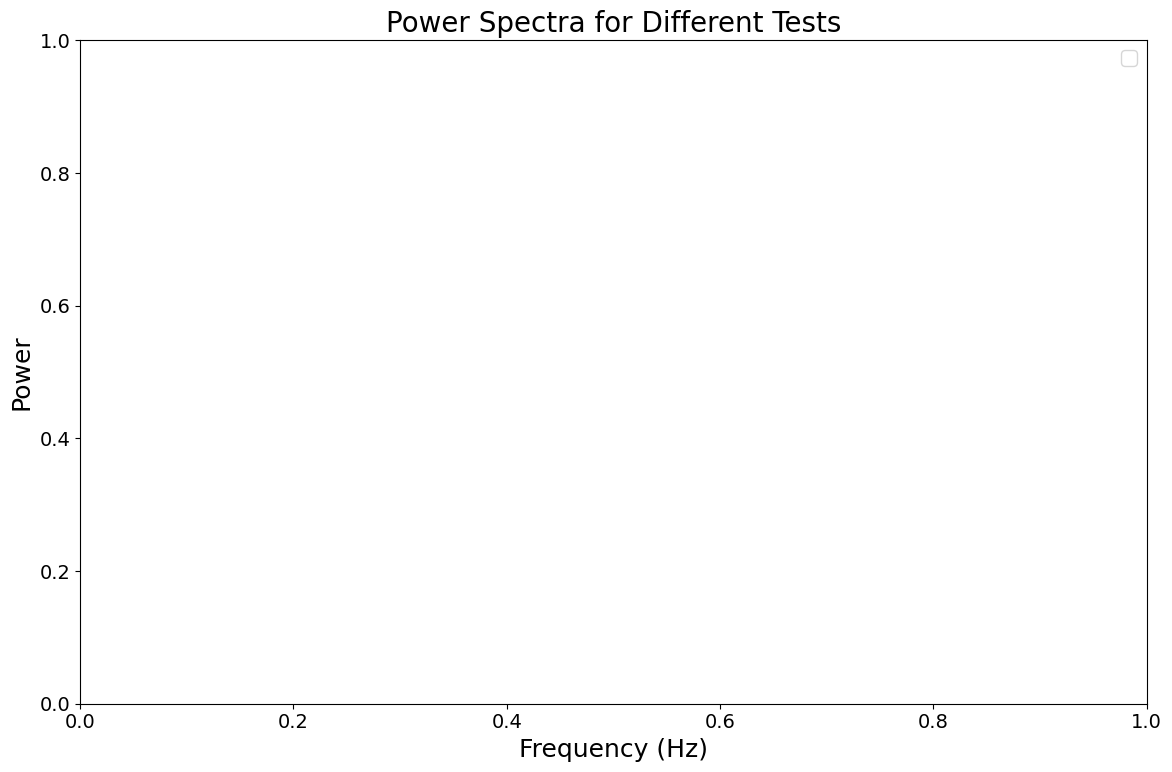

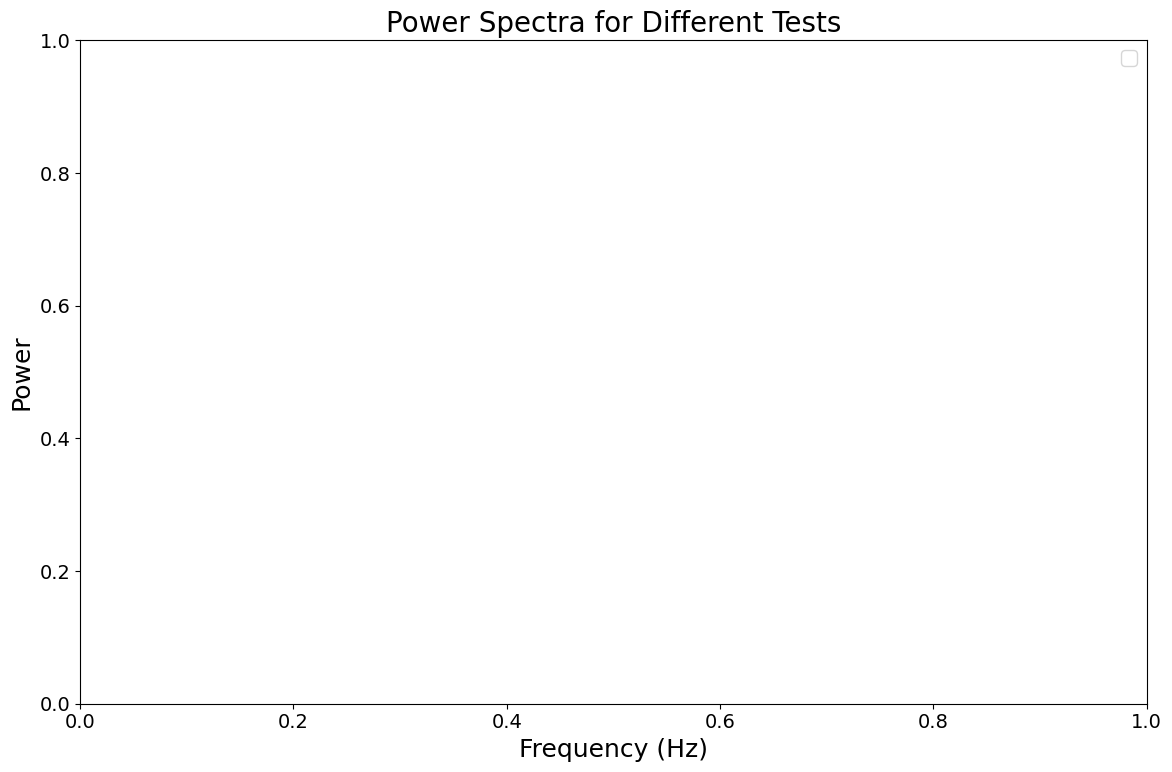

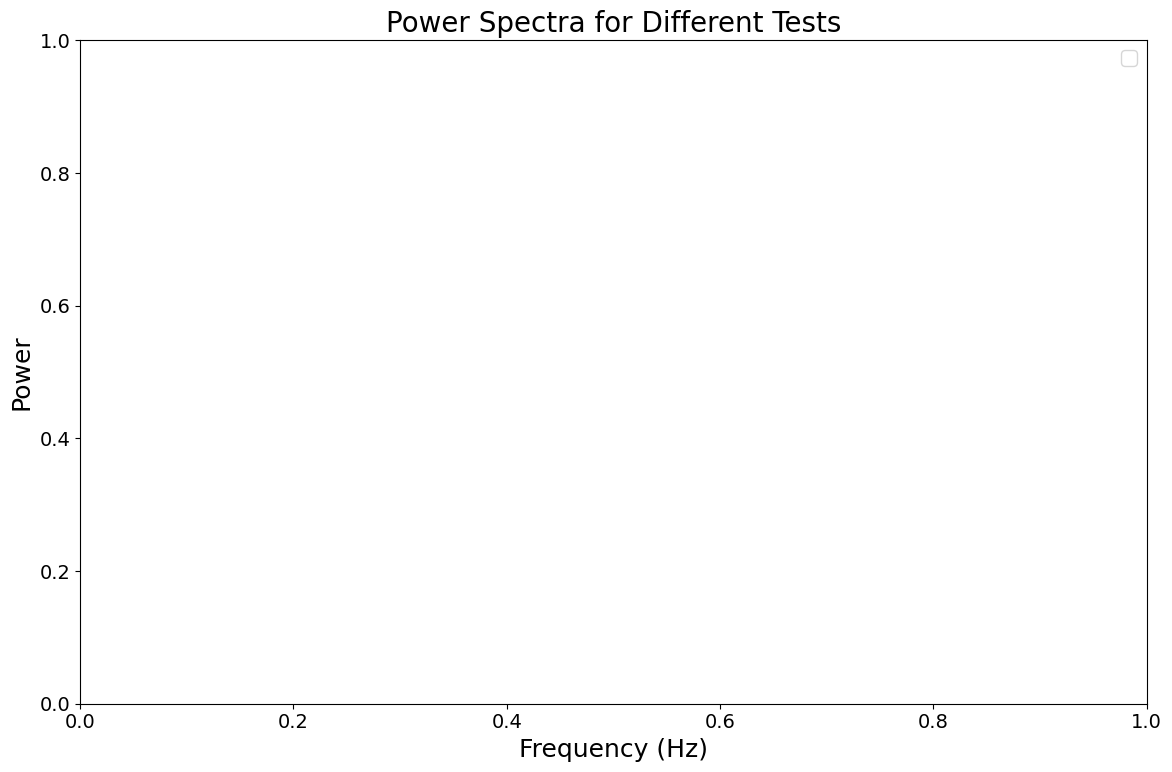

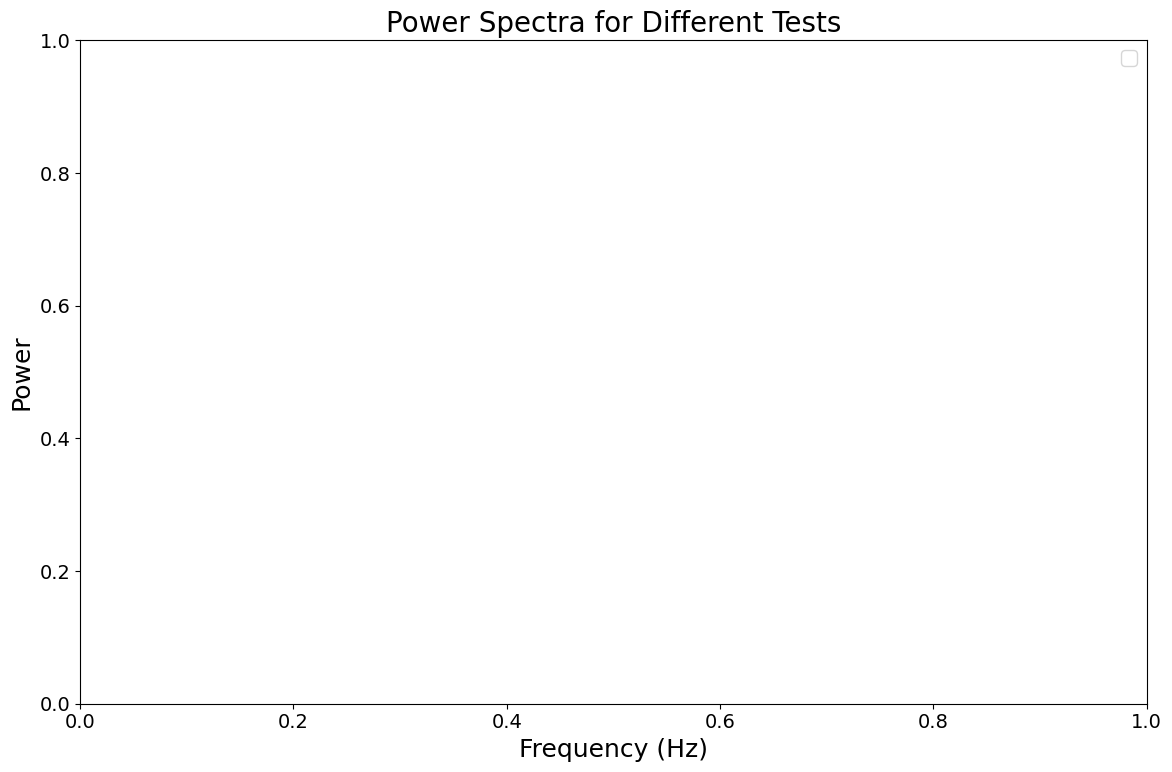

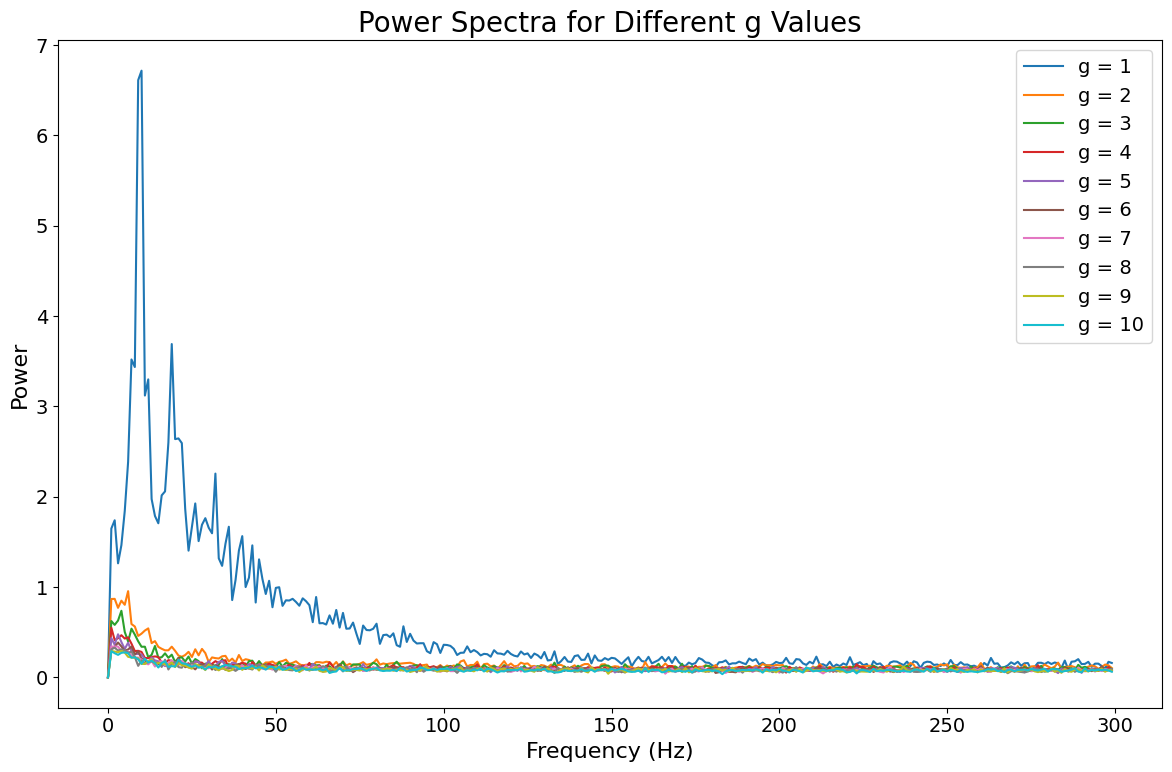

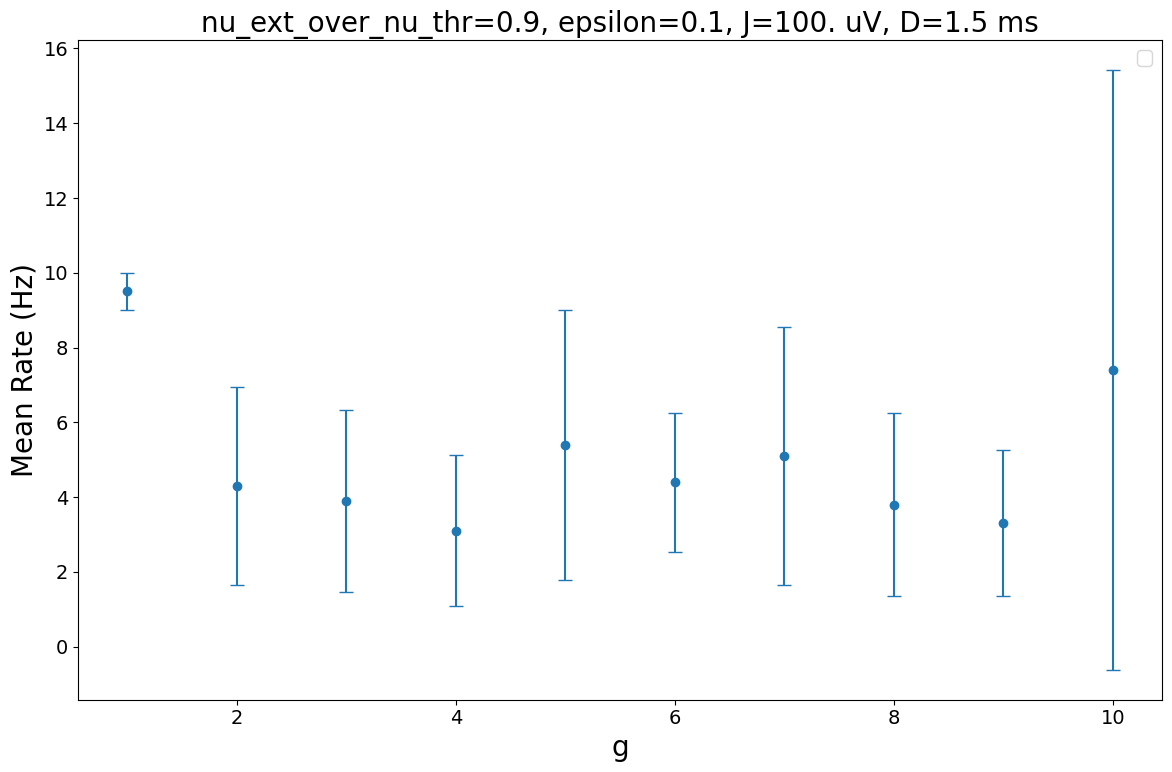

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def sim(g, nu_ext_over_nu_thr, sim_time, epsilon, J, D, plot=False):
    start_scope()
    # network parameters
    N_E = 800
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 20 * ms
    theta = 20 * mV
    V_r = 10 * mV
    tau_rp = 2 * ms

    # synapse parameters
    D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)
    nu_ext = nu_ext_over_nu_thr * nu_thr

    defaultclock.dt = 0.1 * ms

    neurons = NeuronGroup(N,
                          "dv/dt = -v/tau : volt (unless refractory)",
                          threshold="v > theta",
                          reset="v = V_r",
                          refractory=tau_rp,
                          method="exact")
    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    exc_synapses = Synapses(excitatory_neurons, target=neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(p=epsilon)

    inhib_synapses = Synapses(inhibitory_neurons, target=neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(p=epsilon)

    external_poisson_input = PoissonInput(
        target=neurons, target_var="v", N=C_ext, 
        rate=nu_ext, 
        weight=J
    )

    rate_monitor = PopulationRateMonitor(neurons)
    spike_monitor = SpikeMonitor(neurons[:50])

    # Запуск симуляции
    run(sim_time)

    rate = rate_monitor.rate/Hz - np.mean(rate_monitor.rate/Hz)

    # Gaussian for the fit
    def func(x, a, x0, sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

    N = len(rate_monitor.t) # number of samples
    sampling_rate = 10000 # 1/defaultclock.dt   
    # number of point to use
    max_point = int(N*300/sampling_rate)
    x = rfftfreq(N, d=1/sampling_rate)
    x = x[:max_point]
    yn = 2*np.abs(rfft(rate))/N
    yn = yn[:max_point]

    max_rate = np.argmax(yn)

    if plot:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'D = {g}', fontsize=16)

        # Первый график (спайки)
        plt.subplot(311)
        plt.plot(spike_monitor.t / ms, spike_monitor.i, '|')
        plt.xlabel('Time (ms)', fontsize=14)
        plt.ylabel('Neuron index', fontsize=14)
        plt.xlim([0, 250])

        # Второй график (частота)
        plt.subplot(312)
        plt.plot(rate_monitor.t / ms, rate_monitor.rate / Hz)
        plt.xlabel('Time (ms)', fontsize=14)
        plt.ylabel('Rate (Hz)', fontsize=14)
        plt.xlim([0, 250])

        # Третий график (функция)
        plt.subplot(313)
        plt.plot(x, yn, c='k', label='Function')
        plt.xlabel('Rate (Hz)', fontsize=14)
        plt.xlim([0, 250])
        plt.show()

    return rate_monitor, spike_monitor, max_rate, x, yn

# Увеличение шрифтов
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'axes.titlesize': 20, 'legend.fontsize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14})

tests = np.arange(0, 10, 1)
g_values = np.arange(1, 11, 1)

spectra = {}
mean_rates = []
std_rates = []

nu_ext_over_nu_thr = 0.9
sim_time = 1000 * ms
epsilon = 0.1
J = 0.1 * mV
D = 1.5 * ms

for g in g_values:
    print('g', round(g, 2))
    max_rates_for_g = []
    spectrum_for_g = []
    plt.figure(figsize=(12, 8))

    for n_test in tests:
        print('n_test', n_test)
        rate_monitor, spike_monitor, max_rate, x, yn = sim(round(g, 1), nu_ext_over_nu_thr, sim_time, epsilon, J, D)
        max_rates_for_g.append(max_rate)
        spectrum_for_g.append(yn)
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('Power Spectra for Different Tests')
    plt.legend()
    plt.tight_layout()

    # Удаляем выбросы
    print(max_rates_for_g)
    
    # Вычисляем среднее и стандартное отклонение
    mean_rates.append(np.mean(max_rates_for_g))
    std_rates.append(np.std(max_rates_for_g))

    spectra[g] = np.mean(spectrum_for_g, axis=0)

# Построение графика спектров
plt.figure(figsize=(12, 8))
for g in g_values:
    plt.plot(x, spectra[g], label=f'g = {g}')

plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Power', fontsize=16)
plt.title('Power Spectra for Different g Values', fontsize=20)
plt.legend()
plt.tight_layout()

# Построение графика средней частоты
plt.figure(figsize=(12, 8))
plt.errorbar(g_values, mean_rates, yerr=std_rates, fmt='o', capsize=5)
plt.ylabel('Mean Rate (Hz)', fontsize=20)
plt.xlabel('g', fontsize=20)
plt.title(f'nu_ext_over_nu_thr={nu_ext_over_nu_thr}, epsilon={epsilon}, J={J}, D={D}', fontsize=20)
plt.tight_layout()
plt.legend()
plt.show()
